In [1]:
import numpy as np
import hdf5storage as sio

# Load connectivity data
conn_66 = sio.loadmat("../data/h66.mat")
weights = conn_66['weights']
tract_lengths = conn_66['tract_lengths']

n_rois = weights.shape[0]
print(f'Number of regions of interest = {n_rois}')

Number of regions of interest = 66


In [2]:
from neuronumba.simulator.models import Naskar
from neuronumba.simulator.connectivity import Connectivity

# Create the connectivity data for the simulation
con = Connectivity(weights=weights, lengths=tract_lengths, speed=1e10)
# Use the Naskar model
m = Naskar()
print(f"Naskar state variables = {m.get_state_vars}, and observable variables = {m.get_observablevars}")

Naskar state variables = ['S_e', 'S_i', 'J'], and observable variables = ['Ie', 're']


In [3]:
from neuronumba.simulator.monitors import RawSubSample
from neuronumba.simulator.coupling import CouplingLinearNoDelays
from neuronumba.simulator.integrators import EulerStochastic

# Set integratin step at 0.1 ms
dt = 0.1
# Use a Euler stochastic integrator. The sigmas vector has to be of the same size as of the state variables
integ = EulerStochastic(dt=dt, sigmas=np.r_[1e-2, 0, 0])

# We are using a coupling with no delays, and with a global coupling linear factor of g=1.0
coupling = CouplingLinearNoDelays(weights=weights, g=1.0)
# We want to sample observable variable with index 1 ('re') every 1 ms
monitor = RawSubSample(period=1.0, state_vars=[], obs_vars=[1])

In [4]:
import time
from neuronumba.simulator.simulator import Simulator

# Create the simulator
s = Simulator(connectivity=con, model=m, coupling=coupling, integrator=integ, monitors=[monitor])

# And run it measuring the execution time
# We run a simulation of 10 sec (100000 ms)
start_time = time.perf_counter()
s.run(0, 100000)
t_sim = time.perf_counter() - start_time
print(f"Simulation time = {t_sim} seconds")

Simulation time = 5.611456190003082 seconds


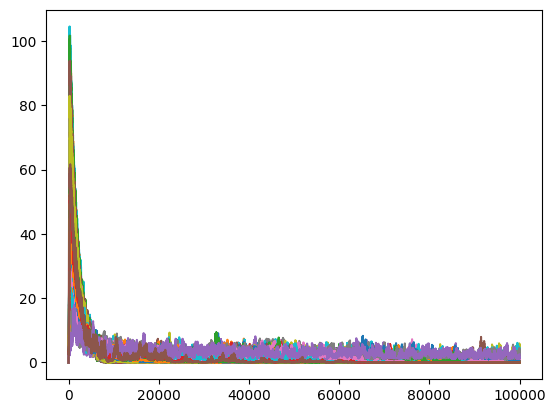

In [5]:
from matplotlib import pyplot as plt

data_observed = monitor.data_observed()
signal = data_observed[:, 0, :]

fig, ax = plt.subplots()
ax.plot(np.arange(signal.shape[0]), signal)
plt.show()